In [1]:
import numpy as np
import tensorflow as tf
# import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
# import pandas as ps
import time
import re
import os
import shutil
import glob
import math

In [2]:
TEST_ID = 'UK.B.A.65'
BASE_TEST_ID = ''  # should be either '' or an existing TEST_ID.
DATA_BITS = 32              #------------------ 16 doesn't work.
STARTING_PERCENT = 0
ENDING_PERCENT = 6          # 0 -> 6
TRAIN_PERCENT= 94
VALID_PERCENT = 3
TEST_PERCENT = 100 - TRAIN_PERCENT - VALID_PERCENT
BUFFER_SIZE = 35000
BATCH_SIZE = 4
LEARNING_RATE = 3e-7 # 1e-6: [:13]    # 1e-6 if BASE_TEST_ID == ''. 
TEAM_EMBS = 50
DROPOUT = 0.0               # 0.1 -> 0.0
TRANSFORMER_LAYERS = 6
TRANSFORMER_HEADS = 60
ADAPTORS_LAYERS = 10
RESET_HISTORY = False
MIN_PROFIT = -1.0
PROFIT_KEYS = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
id_to_ids_filename = 'England-300-1e-07-7300-75-0.9-False'

In [3]:
if DATA_BITS == 32:
    NP_INT = np.int32; NP_FLOAT = np.float32; TF_INT = tf.int32; TF_FLOAT = tf.float32
elif DATA_BITS == 16:
    NP_INT = np.int16; NP_FLOAT = np.float16; TF_INT = tf.int16; TF_FLOAT = tf.float16

from config import config
config['np_int'] = NP_INT; config['np_flaot'] = NP_FLOAT; config['tf_int'] = TF_INT; config['tf_float'] = TF_FLOAT

import data_helpers
from data_generator import *

config types: <class 'numpy.int32'> <class 'numpy.float32'> <dtype: 'int32'> <dtype: 'float32'>


In [4]:
tf.random.set_seed(47)  # yes, just 47.

In [5]:
countryDirPath = "./data/football-data-co-uk/England"
df = data_helpers.get_master_df_from_football_data_co_uk(countryDirPath)

In [6]:
tokenizer_team = creat_team_tokenizer_uk(df)
print(tokenizer_team.get_vocab_size())

teams = ['Tottenham', 'Arsenal', 'Liverpool', 'what?', 'Tottenham', 'Chelsea', 'e_t', 'Man United', '1234', '[HOME]', '[AWAY]']
teams = [team.strip() for team in [re.sub(r"\s", "_", item) for item in teams]]
teams = " ".join(teams)
encoding = tokenizer_team.encode(teams)
# encoding = tokenizer.encode("")
print(encoding.tokens)
print(encoding.type_ids)
print(encoding.ids)

tokenizer_team.decode(encoding.ids)

113
['tottenham', 'arsenal', 'liverpool', '[UNK]', 'tottenham', 'chelsea', '[UNK]', 'man_united', '[UNK]', '[UNK]', '[UNK]']
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[101, 4, 58, 0, 101, 27, 0, 62, 0, 0, 0]


'tottenham arsenal liverpool tottenham chelsea man_united'

In [7]:
class hyperparams:    
    nDivisions = 4 + 1  # E0, E1, E2, E3, and Unknown
    division_embs = 4
    nTeams = tokenizer_team.get_vocab_size()    # including Unknown
    team_embs = TEAM_EMBS
    nGoals  = 10  # 0 for 0 goals not for Unknown.
    goal_embs = 4
    nResults = 4    # HWin, Draw, AWin, and Unknown
    result_embs = 4
    # Mate d_model an even number!!!
    d_model = get_std_size()    + division_embs * len(Div_cols) + team_embs * len(Team_cols) \
                                + goal_embs * len(Goal_cols) + result_embs * len(Result_cols)
    batch_size = BATCH_SIZE
    days_spanning_years = 30
    num_layers = TRANSFORMER_LAYERS
    num_heads = TRANSFORMER_HEADS
    m365_size = 1
    initial_m365 = 0.9
    # d_model = team_emb_size * 2 + country_emb_size * 3 + odds_size + outcome_size

In [8]:
filepath = os.path.join(os.getcwd(), 'data', 'id_to_ids', id_to_ids_filename + '.json')
id_to_ids = data_helpers.LoadJsonData(filepath)

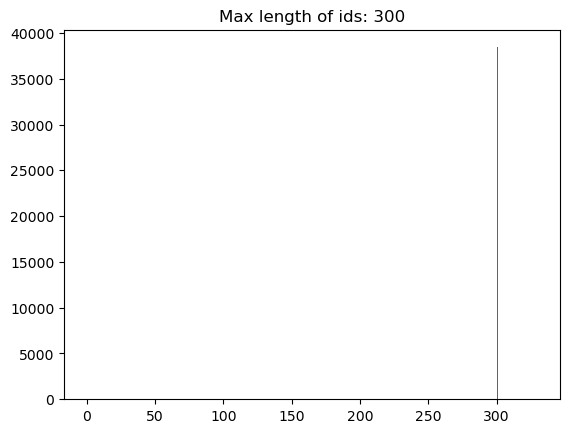

In [9]:
lengths = [len(ids) for (tag, label, ids) in id_to_ids.values()]
maxLen = max(lengths)
plt.hist(lengths, np.linspace(0, int(maxLen*1.1), int(maxLen*1.1) + 1))
plt.ylim(plt.ylim())
maxLen = max(lengths)
# plt.plot([maxLen, maxLen], plt.ylim())
plt.title(f'Max length of ids: {maxLen}')

MAX_TOKENS = maxLen

In [10]:
id_cols = ['id']
Div_cols = ['Div']
Date_cols = ['Date']
Team_cols = ['HomeTeam', 'AwayTeam']
Odds_cols = ['B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'WHH', 'WHD', 'WHA']
BB_cols = id_cols + Div_cols + Date_cols + Team_cols + Odds_cols

Half_Goal_cols = ['HTHG', 'HTAG']
Full_Goal_cols = ['FTHG', 'FTAG']
Goal_cols = Half_Goal_cols + Full_Goal_cols
Result_cols = ['HTR', 'FTR']    # A function of Goal_cols, but contribute to better representation.
Shoot_cols = ['HS', 'AS']
ShootT_cols = ['HST', 'AST']
Corner_cols = ['HC', 'AC']
Faul_cols = ['HF', 'AF']
Yellow_cols = ['HY', 'AY']    # H/A Yellow Cards, H/A Red Cards
Red_cols = ['HR', 'AR']    # H/A Yellow Cards, H/A Red Cards
AB_cols = Goal_cols + Result_cols + Shoot_cols + ShootT_cols + Corner_cols + Faul_cols + Yellow_cols + Red_cols

# underscore_prefixed lists have discontinued columns.
BBAB_cols = BB_cols + AB_cols
_Cols_List_to_Embedd = [Div_cols, Team_cols, Goal_cols, Result_cols]
_Cols_List_to_Standardize = [Odds_cols, Shoot_cols, ShootT_cols, Corner_cols, Faul_cols, Yellow_cols, Red_cols]
_Cols_List_for_Label = [Full_Goal_cols, Odds_cols]
_Label_cols = Full_Goal_cols + Odds_cols

BBAB_cols = BB_cols + AB_cols
base_bbab = list(df.loc[df['id'] == 100000, BBAB_cols].iloc[0, :])
print(base_bbab)

[100000, 'E0', datetime.date(2004, 1, 11), 'Man_City', 'Norwich', 1.72, 3.4, 5.0, 1.7, 3.2, 5.0, 1.65, 3.3, 4.4, 1.66, 3.1, 5.0, 1.0, 0.0, 1, 1, 'H', 'D', 19.0, 10.0, 11.0, 5.0, 9.0, 4.0, 10.0, 13.0, 1.0, 0.0, 0.0, 0.0]


In [11]:
std_path = os.path.join('./data', 'datasets', id_to_ids_filename + ".json")
std_params = get_standardization_params(df)
print(std_params)
data_helpers.SaveJsonData(std_params, std_path)
std_params = data_helpers.LoadJsonData(std_path)

{'B365H': (3.1630270400481795, 1.4687447460469159, 46.0), 'HS': (11.39694154084398, 4.709404811489129, 43.0), 'HST': (4.815343915343916, 2.759941394538306, 24.0), 'HC': (5.34632855852368, 2.842282967456132, 24.0), 'HF': (11.421925409730287, 3.7612036770331043, 77.0), 'HY': (1.5455413601755066, 1.2348960213340971, 11.0), 'HR': (0.08013937282229965, 0.2855927650445304, 3.0)}


In [12]:
ds_path = os.path.join('./data', 'datasets', id_to_ids_filename + '_' + str(DATA_BITS))

if os.path.exists(ds_path):
    ds = tf.data.Dataset.load(ds_path)
else:
    ds = generate_dataset_uk(df, id_to_ids, tokenizer_team, std_params)
    tf.data.Dataset.save(ds, ds_path)
    ds = tf.data.Dataset.load(ds_path)

len(ds)

38745

In [13]:
total_size = len(ds)

starting_size = int(STARTING_PERCENT/100 * total_size)
ending_size = int(ENDING_PERCENT/100 * total_size)
take_size = total_size - starting_size - ending_size
remaining_ds = ds.skip(starting_size)
dataset = remaining_ds.take(take_size)

dataset_size = len(dataset)

train_size = int(TRAIN_PERCENT/100 * dataset_size)
valid_size = int(VALID_PERCENT/100 * dataset_size)
test_size = dataset_size - train_size - valid_size

_train_ds = dataset.take(train_size)                # [: train_size]
remaining_ds = dataset.skip(train_size - valid_size)     # [train_size - valid_size: ]

_back_ds = remaining_ds.take(valid_size)            # [train_size - valid_size, train_size]
remaining_ds = remaining_ds.skip(valid_size)        # [train_size: ]

_valid_ds = remaining_ds.take(valid_size)            # [train_size, train_size + valid_size]
_test_ds = remaining_ds.skip(valid_size)             # [train_size + valid_size :]

assert len(_test_ds) == test_size

assert dataset_size == len(_train_ds) + len(_valid_ds) + len(_test_ds)

print(total_size, len(dataset), len(_train_ds), len(_back_ds), len(_valid_ds), len(_test_ds))

38745 36421 34235 1092 1092 1094


In [14]:
dummy_bbas_tensor = get_dummy_bbas_tensor_uk(df, tokenizer_team, std_params)

In [15]:
def normalize_row(baseId, sequence, base_bb, base_label):
    try:
        seq_len_org = sequence.shape[0]
        nMissings = MAX_TOKENS - seq_len_org
        if nMissings > 0:
            block = tf.stack([dummy_bbas_tensor] * nMissings, axis=0)
            sequence = tf.concat([sequence, block], axis=0) 
        # print("sequence 1", sequence.shape)
        # sequence[:, 2] = base[2] - sequence[:, 2]   # get delta days.
        base_bb = base_bb[tf.newaxis, :]    # shape: (seq_len = 1, nFeatures)
        mask = tf.Variable([1] * seq_len_org + [0] * nMissings, dtype=TF_INT) ## DO NOT USE tf.constant !!! unstable.
        mask = mask[:, tf.newaxis] & mask[tf.newaxis, :]
        # print('normalize', sequence.shape, base.shape, mask.shape, mask)
        # seq_len_org = tf.Variable(seq_len_org, dtype=TF_INT)
        return (baseId, sequence, base_bb, base_label, mask, seq_len_org)
    except:
        print('normalize_row exception')
        print('norm 1', sequence.shape, base_bb.shape, base_label.shape, mask.shape, nMissings)
        print('norm 2', baseId, sequence, base_label, mask, nMissings)
        # return (baseId, sequence, base_bb, base_label, mask, seq_len_org)

def prepare_batch(baseId, sequence, base_bb, base_label, mask, seq_len_org):
    # target = tf.one_hot(tf.squeeze(tf.cast(base_bbab[:, :, -1], dtype=TF_INT), axis=-1), hyperparams.target_onehot_size)
    return (baseId, sequence, base_bb, mask), (base_label, seq_len_org)     # (X, Y)

def normalize_dataset(ds):
    return (
        ds.map(lambda baseId, sequence, base_bb, base_label: tf.py_function(
            func=normalize_row,
            inp=[baseId, sequence, base_bb, base_label],
            Tout=[TF_INT, TF_FLOAT, TF_FLOAT, TF_FLOAT, TF_INT, TF_INT])) #, tf.data.AUTOTUNE == Instability!!!
        )

train_batch_size = BATCH_SIZE
test_batch_size = BATCH_SIZE * 2

def make_train_batches(ds):
    return (
        ds
        .shuffle(BUFFER_SIZE)
        .batch(train_batch_size)
        .map(prepare_batch, tf.data.AUTOTUNE)
        .cache()
        .prefetch(buffer_size=tf.data.AUTOTUNE)
        )

def make_test_batches(ds):
    return (
        ds
        .batch(test_batch_size)
        .map(prepare_batch, tf.data.AUTOTUNE)
        .cache()
        .prefetch(buffer_size=tf.data.AUTOTUNE)
        )

In [16]:
train_ds_path = os.path.join('./data', 'datasets', id_to_ids_filename +  '_' + str(DATA_BITS) + '_' \
        + str(starting_size) + '_' + str(len(_train_ds)) )

if os.path.exists(train_ds_path):
    train_ds = tf.data.Dataset.load(train_ds_path)
else:
    train_ds = normalize_dataset(_train_ds)
    tf.data.Dataset.save(train_ds, train_ds_path)

print(len(train_ds))

train_batches = make_train_batches(train_ds)

0


In [17]:
cnt = 3
for z in train_batches:
    (baseId, sequence, base_bb, mask), (base_label, seq_len_org) = z
    cnt -= 1
    if cnt == 0: break
print(baseId.shape, sequence.shape, base_bb.shape, mask.shape, base_label.shape, seq_len_org.shape)
sample_x = (sequence, base_bb, mask)
sample_y = (base_label, seq_len_org)

(4,) (4, 300, 35) (4, 1, 17) (4, 300, 300) (4, 14) (4,)


In [18]:
back_ds_path = os.path.join('./data', 'datasets', id_to_ids_filename +  '_' + str(DATA_BITS) + '_' \
        + str(starting_size) + '_' + str(len(train_ds)) + '_' + str(len(_back_ds)) )
if os.path.exists(back_ds_path):
    back_ds = tf.data.Dataset.load(back_ds_path)
else:
    back_ds = normalize_dataset(_back_ds)
    tf.data.Dataset.save(back_ds, back_ds_path)

print(len(back_ds))

back_batches = make_test_batches(back_ds)

1092


In [19]:
valid_ds_path = os.path.join('./data', 'datasets', id_to_ids_filename +  '_' + str(DATA_BITS) + '_' \
        + str(starting_size) + '_' + str(len(train_ds)) + '_' + str(len(back_ds)) + '_' + str(len(_valid_ds)) )
if os.path.exists(valid_ds_path):
    valid_ds = tf.data.Dataset.load(valid_ds_path)
else:
    valid_ds = normalize_dataset(_valid_ds)
    tf.data.Dataset.save(valid_ds, valid_ds_path)

print(len(valid_ds))

valid_batches = make_test_batches(valid_ds)

1092


In [20]:
test_ds_path = os.path.join('./data', 'datasets', id_to_ids_filename +  '_' + str(DATA_BITS) + '_' \
        + str(starting_size) + '_' + str(len(train_ds)) + '_' + str(len(back_ds)) + '_' + str(len(valid_ds)) + '_' + str(len(_test_ds)))
if os.path.exists(test_ds_path):
    test_ds = tf.data.Dataset.load(test_ds_path)
else:
    test_ds = normalize_dataset(_test_ds)
    tf.data.Dataset.save(test_ds, test_ds_path)

print(len(test_ds))

test_batches = make_test_batches(test_ds)

1094


In [21]:
def positional_encoding(memory, depth):
    positions = tf.range(memory.shape[-1], dtype=TF_FLOAT)
    fractional_pos = memory * positions    # fractional position: (batch, fractional position #)
    depth = depth/2
    depths = tf.range(depth, dtype=TF_FLOAT) / depth
    depths = tf.pow(10000.0, depths)    # (depth,)
    angle_rads = fractional_pos[:, :, tf.newaxis] / depths  # (batch, fractional position #, depth)
    # pos_encoding = rearrange([tf.math.sin(angle_rads), tf.math.cos(angle_rads)], 'w b p d -> w h (w t)')
    pos_encoding = tf.concat([tf.math.sin(angle_rads), tf.math.cos(angle_rads)], axis=-1)
    return pos_encoding

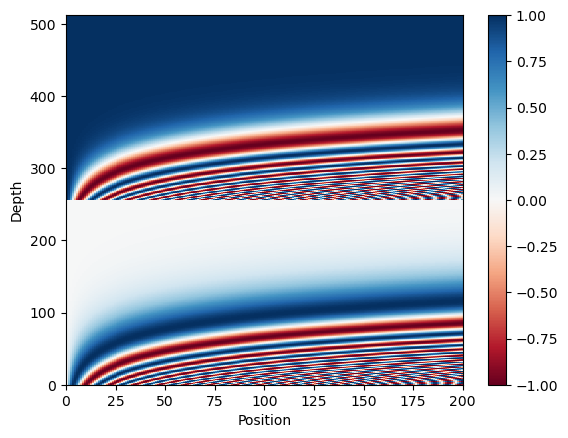

In [22]:
memory = tf.ones((100, 200), dtype=TF_FLOAT) * 0.5
pos_encoding = positional_encoding(memory, depth=512)
# print('pos_encoding', pos_encoding.shape)
pos_encoding = pos_encoding[0, :, :]
# print(pos_encoding.shape)
# Plot the dimensions.
plt.pcolormesh(pos_encoding.numpy().T, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

In [23]:
id_cols = ['id']
Div_cols = ['Div']
Date_cols = ['Date']
Team_cols = ['HomeTeam', 'AwayTeam']
Odds_cols = ['B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH', 'IWD', 'IWA', 'WHH', 'WHD', 'WHA']
BB_cols = id_cols + Div_cols + Date_cols + Team_cols + Odds_cols

Half_Goal_cols = ['HTHG', 'HTAG']
Full_Goal_cols = ['FTHG', 'FTAG']
Goal_cols = Half_Goal_cols + Full_Goal_cols
Result_cols = ['HTR', 'FTR']    # A function of Goal_cols, but contribute to better representation.
Shoot_cols = ['HS', 'AS']
ShootT_cols = ['HST', 'AST']
Corner_cols = ['HC', 'AC']
Faul_cols = ['HF', 'AF']
Yellow_cols = ['HY', 'AY']    # H/A Yellow Cards, H/A Red Cards
Red_cols = ['HR', 'AR']    # H/A Yellow Cards, H/A Red Cards
AB_cols = Goal_cols + Result_cols + Shoot_cols + ShootT_cols + Corner_cols + Faul_cols + Yellow_cols + Red_cols

In [24]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, hyperparams, isEncoder=True):
    super().__init__()
    self.isEncoder = isEncoder
    self.division_embedding = tf.keras.layers.Embedding(hyperparams.nDivisions, hyperparams.division_embs, dtype=TF_FLOAT, mask_zero=False) # Learn Unknown
    self.team_embedding = tf.keras.layers.Embedding(hyperparams.nTeams, hyperparams.team_embs, dtype=TF_FLOAT, mask_zero=False) # Learn Unknown
    self.goal_embedding = tf.keras.layers.Embedding(hyperparams.nGoals, hyperparams.goal_embs, dtype=TF_FLOAT, mask_zero=False) # Learn 0-goal
    self.result_embedding = tf.keras.layers.Embedding(hyperparams.nResults, hyperparams.result_embs, dtype=TF_FLOAT, mask_zero=False) # Learn Unknown

    self.d_model = hyperparams.d_model
    # print(self.d_model)
    self.position_permuting_dense = tf.keras.layers.Dense(self.d_model)
    self.m365_embedding = tf.keras.layers.Embedding(1, hyperparams.m365_size, mask_zero=False, embeddings_initializer = tf.keras.initializers.Ones())

    self.idx_Days = BB_cols.index('Date')
    assert self.idx_Days == BBAB_cols.index('Date')

  def call(self, x):
    (sequence, base_bb, mask) = x # sob = sequence or base_bb
    sDays = sequence[:, :, self.idx_Days]
    bDays = base_bb[:, :, self.idx_Days]
    
    # BB_cols = id_cols + Div_cols + Date_cols + Team_cols + Odds_cols
    # AB_cols = Goal_cols + Result_cols + Shoot_cols + ShootT_cols + Corner_cols + Faul_cols + Yellow_cols + Red_cols

    sob = None
    if self.isEncoder:
      sob = sequence
    else:
      sob = base_bb

    if self.isEncoder:
      # Extract odds to remove them
      id, div, days, teams, odds, goals, results, remainder \
      = tf.split(sob, [len(id_cols), len(Div_cols), len(Date_cols), len(Team_cols), len(Odds_cols), len(Goal_cols), len(Result_cols),  -1], axis=-1)
      # print('1', remainder[0, 0])
    else:
      # Extract odds to remove them
      id, div, days, teams, odds, remainder \
      = tf.split(sob, [len(id_cols), len(Div_cols), len(Date_cols), len(Team_cols), len(Odds_cols), -1], axis=-1)  
      # print('2', remainder[0, 0])  

    # print('pe 2.7.1 1', div)
    div = self.division_embedding(tf.cast(div, dtype=TF_INT))
    div = tf.reshape(div, [div.shape[0], div.shape[1], -1])
    # print('pe 2.7.1 1', div)
    teams = self.team_embedding(tf.cast(teams, dtype=TF_INT))
    teams = tf.reshape(teams, [teams.shape[0], teams.shape[1], -1])
    if self.isEncoder:
      goals = self.goal_embedding(tf.cast(goals, dtype=TF_INT))
      goals = tf.clip_by_value(goals, 0, hyperparams.nGoals)
      goals = tf.reshape(goals, [goals.shape[0], goals.shape[1], -1])
      results = self.result_embedding(tf.cast(results, dtype=TF_INT))
      results = tf.reshape(results, [results.shape[0], results.shape[1], -1])

    # prob = 1.0 / odds   # U.HO.05
    
    if self.isEncoder:
      concat = [div, teams, goals, results, odds, remainder]
    else:
      concat = [div, teams, odds, remainder]

    sob = tf.concat(concat, axis=-1)
    sob = self.position_permuting_dense(sob)

    days_ago = tf.cast(bDays - sDays, dtype=TF_FLOAT) if self.isEncoder else tf.cast(bDays - bDays, dtype=TF_FLOAT)
    
    m365 = self.m365_embedding(tf.zeros_like((hyperparams.m365_size,), dtype=TF_FLOAT)) * hyperparams.initial_m365  # expected shape: (1, hyperparams.remain_365_size)
    m365 = tf.squeeze(m365, axis=0)
    memory_alpha = tf.math.pow(m365, 1.0/365) # (hyperparams.m365_size,)
    memory = tf.math.pow(memory_alpha, tf.cast(days_ago[:, :, tf.newaxis], tf.float32))  # decrease as days_ago increase, if memory <= 1.0 as expected.
    memory = tf.reduce_mean(memory, axis=-1)

    pe = positional_encoding(memory, depth=sob.shape[-1]) # (batch, d_model)
    pe = pe / tf.math.sqrt(tf.cast(sob.shape[-1], TF_FLOAT))
    sob = sob + pe

    if self.isEncoder:
      mask = mask
    else:
      mask = mask[:, 0:sob.shape[1], :]

    return (sob, mask)

In [25]:
PE = PositionalEmbedding(hyperparams, isEncoder=True)
eSob, eMask = PE(sample_x)
print(eSob.shape, eMask.shape )
del PE

(4, 300, 152) (4, 300, 300)


In [26]:
PE = PositionalEmbedding(hyperparams, isEncoder=False)
dSob, dMask = PE(sample_x)
print(dSob.shape, dMask.shape )
del PE

(4, 1, 152) (4, 1, 300)


In [27]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
      super().__init__()
      self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
      self.layernorm = tf.keras.layers.LayerNormalization()   # So the default -1 axix is normalized across. No inter-token operatoin.
      self.add = tf.keras.layers.Add()

class CrossAttention(BaseAttention):
    def call(self, x, context, mask):
      attn_output, attn_scores = self.mha(
          query=x,
          key=context,
          value=context,
          attention_mask=mask,
          return_attention_scores=True)
    
      # Cache the attention scores for plotting later.
      self.last_attn_scores = attn_scores
      x = self.add([x, attn_output])
      x = self.layernorm(x)
      return x
  
class GlobalSelfAttention(BaseAttention): 
    def call(self, x, mask):
      attn_output = self.mha(
          query=x,
          value=x,
          key=x,
          attention_mask=mask)    # intentional inter-token operation
      x = self.add([x, attn_output])  # token-wise
      x = self.layernorm(x)         # normalize across the default -1 axis. No inter-token operatoin.
      return x
  
class CausalSelfAttention(BaseAttention): # mask-agnostic
    def call(self, x):
      attn_output = self.mha(
          query=x,
          value=x,
          key=x,
          use_causal_mask = True)     # look-over mask is generagted and used, in decoder layers
      x = self.add([x, attn_output])  # mask-agnostic
      x = self.layernorm(x)  # normalize across the default -1 axis. No inter-token operatoin.
      return x
  
class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
      super().__init__()
      self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),    # across -1 axis
        tf.keras.layers.Dense(d_model),    # across -1 axis
        tf.keras.layers.Dropout(dropout_rate)    # mask-agnostic
      ])
      self.add = tf.keras.layers.Add()
      self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
      x = self.add([x, self.seq(x)])  # mask-agnostic
      x = self.layer_norm(x)  # normalize across the default -1 axis. No inter-token operatoin.
      return x
  
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self,*, d_model, num_heads, dff, dropout_rate=0.1):
      super().__init__()

      self.self_attention = GlobalSelfAttention(
          num_heads=num_heads,
          key_dim=d_model,
          dropout=dropout_rate)

      self.ffn = FeedForward(d_model, dff)

    def call(self, x, mask):
      # x: (batch, max_tokens, d_model), mask: (batch, max_tokens, max_tokens)
      x = self.self_attention(x, mask)
      x = self.ffn(x)
      return x
  
class Encoder(tf.keras.layers.Layer):
    def __init__(self, hyperparams, dropout_rate=0.1):
      super().__init__()

      self.d_model = hyperparams.d_model
      self.num_layers = hyperparams.num_layers

      self.pos_embedding = PositionalEmbedding(hyperparams)

      self.dropout = tf.keras.layers.Dropout(dropout_rate)
      self.enc_layers = [
          EncoderLayer(d_model=hyperparams.d_model,
                      num_heads=hyperparams.num_heads,
                      dff=hyperparams.d_model * 4,
                      dropout_rate=dropout_rate)
          for _ in range(hyperparams.num_layers)]

    def call(self, x):
      # x = (sequence, base_bb, mask)
      # x[0]: (batch, max_tokens, bbab.len), x[1]: (batch, 1, bb.len), x[2]: (token, max_tokens, max_tokens)
      x, mask = self.pos_embedding(x)  # x: (batch, max_tokens, d_model), mask: (batch, max_tokens, max_tokens)
      x = self.dropout(x)
      for encoder_layer in self.enc_layers:
        x = encoder_layer(x, mask)
      return x  # Shape `(batch_size, seq_len, d_model)`.
  
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self,
                *,
                d_model,
                num_heads,
                dff,
                dropout_rate=0.1):
      super(DecoderLayer, self).__init__()

      self.causal_self_attention = CausalSelfAttention(
          num_heads=num_heads,
          key_dim=d_model,
          dropout=dropout_rate)
      
      self.cross_attention = CrossAttention(
          num_heads=num_heads,
          key_dim=d_model,
          dropout=dropout_rate)

      self.ffn = FeedForward(d_model, dff)

    def call(self, x, context, cross_attention_mask):
      # x: (batch, 1, d_model), context: (batch, max_tokens, d_mode)
      x = self.causal_self_attention(x=x)
      x = self.cross_attention(x, context, cross_attention_mask)

      # Cache the last attention scores for plotting later
      self.last_attn_scores = self.cross_attention.last_attn_scores

      x = self.ffn(x)  # Shape `(batch_size, seq_len, d_model)`.
      return x
  
class Decoder(tf.keras.layers.Layer):
    def __init__(self, hyperparams, dropout_rate=0.1):
      super(Decoder, self).__init__()

      self.d_model = hyperparams.d_model
      self.num_layers = hyperparams.num_layers

      self.pos_embedding = PositionalEmbedding(hyperparams, isEncoder=False)

      self.dropout = tf.keras.layers.Dropout(dropout_rate)
      self.dec_layers = [
          DecoderLayer(d_model=hyperparams.d_model, num_heads=hyperparams.num_heads,
                      dff=hyperparams.d_model * 4, dropout_rate=dropout_rate)
          for _ in range(hyperparams.num_layers)]

      self.last_attn_scores = None

    def call(self, x, context):
      # x = (sequence, base_bb, mask)
      # x[0]: (batch, max_tokens, bbab.len), x[1]: (batch, 1, bb.len), x[2]: (token, max_tokens, max_tokens)
      # context: (batch, max_tokens, d_model)
      # `x` is token-IDs shape (batch, target_seq_len)
      x, ca_mask = self.pos_embedding(x)  # x: (batch, 1, d_model), ca_mask: (batch, 1, max_tokens)     
      x = self.dropout(x)
      for decoder_layer in self.dec_layers:
        x  = decoder_layer(x, context, ca_mask)
      self.last_attn_scores = self.dec_layers[-1].last_attn_scores
      return x
  
class Transformer(tf.keras.Model):
    def __init__(self, hyperparams, dropout_rate=0.1):
      super().__init__()
      self.encoder = Encoder(hyperparams, dropout_rate=dropout_rate)

      self.decoder = Decoder(hyperparams, dropout_rate=dropout_rate)

      self.final_layer = tf.keras.layers.Dense(hyperparams.d_model) #-------------- to modify

    def call(self, inputs):
      # inputs = (sequence, base_bb, mask)
      # sequence: (batch, max_token, aabb), base: (batch, 1, bb), mask: (batch, max_token, max_token)
      x = self.encoder(inputs)  # (batch, max_tokens, d_model)
      x = self.decoder(inputs, x)  # (batch, 1, d_model)
      logits = self.final_layer(x)  # (batch, 1, d_model)
      logits = tf.squeeze(logits, axis=-2)  # (batch, d_model)
      return logits

In [28]:
sample_transformer = Transformer(hyperparams)
y = sample_transformer(sample_x)

sample_transformer.summary()
del sample_transformer

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  34581015  
                                                                 
 decoder (Decoder)           multiple                  68012143  
                                                                 
 dense_28 (Dense)            multiple                  23256     
                                                                 
Total params: 102,616,414
Trainable params: 102,616,414
Non-trainable params: 0
_________________________________________________________________


In [29]:
class Adaptor(tf.keras.layers.Layer):
  def __init__(self, nLayers, d_output, dropout_rate=0.1):
    super().__init__()
    dims = [hyperparams.d_model * 2] * nLayers
    dims = dims + [hyperparams.d_model * 2 + round( (d_output - hyperparams.d_model * 2) * (layer+1) / (nLayers) ) for layer in range(nLayers)]
    layers = [tf.keras.layers.Dense(dim, kernel_initializer=tf.keras.initializers.LecunUniform(), activation='relu') for dim in dims]
    self.seq = tf.keras.Sequential(layers)
  def call(self, x):
    x = self.seq(x)
    return x

class BaseAdaptor(tf.keras.layers.Layer):
  def __init__(self, nLayers, d_output, dropout_rate=0.1):
    super().__init__()
    dims = [hyperparams.d_model] * nLayers + [hyperparams.d_model + round( (d_output - hyperparams.d_model) * (layer+1) / (nLayers) ) for layer in range(nLayers)]
    layers = [tf.keras.layers.Dense(dim, activation='relu') for dim in dims]
    self.seq = tf.keras.Sequential(layers)
  def call(self, x):
    x = self.seq(x)
    return x

class OhAdaptor(tf.keras.layers.Layer):
  def __init__(self, nLayers, d_output, dropout_rate=0.1):
    super().__init__()
    dims = [d_output] * nLayers
    layers = [tf.keras.layers.Dense(dim, activation='relu') for dim in dims]
    self.seq = tf.keras.Sequential(layers)
  def call(self, x):
    x = self.seq(x)
    return x

In [30]:
class BettingEPL(tf.keras.Model):
  softmax = tf.keras.layers.Softmax(axis=-1)

  def __init__(self, hyperparams, nQueries, dropout_rate=0.1):
      super().__init__()
      self.nQueries = nQueries
      self.transformer = Transformer(hyperparams, dropout_rate=dropout_rate)
      self.bookies = ['B365', 'Betfair', 'Interwetten', 'William']
      self.baseAdaptors = [Adaptor(ADAPTORS_LAYERS, self.nQueries) for _ in self.bookies]
      return

  def call(self, input):
      x = self.transformer(input)
      stake_p = [adaptor(x) for adaptor in self.baseAdaptors]  # [(batch, nQueries)] * nBookies
      stake_p = tf.stack(stake_p, axis=0)   # (nBookies, batch, nQueries)
      stake_p = BettingEPL.softmax(stake_p)  # (nBookies, batch, nQueries)
      outputs = (stake_p) # (nBookies, batch, nQueries)
      return outputs  # happen_p: (nBookies, batch, nQueries), stake_p: (nBookies, batch, nQueries)
  
  def h_true(self, ftGoals):  # Defines this QGroup. This is for 1X2 QGroup. Derived classes re-define this funciton.
      # ftGoals:  (batch, 2)
      ftGoals = tf.cast(ftGoals, dtype=TF_INT)  # (batch, 2)
      h = (tf.math.greater(ftGoals[..., 0], ftGoals[..., 1]), tf.math.equal(ftGoals[..., 0], ftGoals[..., 1]), tf.math.less(ftGoals[..., 0], ftGoals[..., 1]))
      h = tf.cast(tf.transpose(h), dtype=TF_FLOAT)  # (batch, nQueries)
      return h

  def loss(self, y, outputs):   
      # y: (batch, len(Team_cols)+len(Odds_cols)) 
      # outputs: stake_p: (nBookies, batch, nQueries)
      ftGoals, odds = tf.split(y, [2, -1], axis=-1) # (batch, 2), (batch, self.nQueries * len(self.bookies))
      odds = tf.split(odds, [self.nQueries] * len(self.bookies), axis=-1)  # [(batch, nQueries)] * nBookies
      odds = tf.stack(odds, axis=0)  # (nBookies, batch, nQueries)
      happen_t = self.h_true(ftGoals) # (batch, nQueries)
      oh = tf.math.multiply(odds, happen_t)   # (nBookies, batch, nQueries)
      (stake_p) = outputs   # (nBookies, batch, nQueries), (nBookies, batch, nQueries)
     
      # -----------------------------------------------------------------------------------------
      # Note: happen_p and stake_p are not converted to one-hot values, unlike they should.
      #------------------------------------------------------------------------------------------
      
      profit_backtest = tf.reduce_mean(tf.reduce_sum(tf.math.multiply(oh - 1.0, stake_p), axis=-1), axis=None)  # () 
      loss = - profit_backtest  # U.action.42
  
      return loss # (), negative average profit on a game on a bookie
  
  def back_test(self, y, outputs, profit_keys):
      # y: (batch, len(Team_cols)+len(Odds_cols)) 
      # outputs: stake_p: (nBookies, batch, nQueries)
      ftGoals, odds = tf.split(y, [2, -1], axis=-1) # (batch, 2), (batch, self.nQueries * len(self.bookies))
      odds = tf.split(odds, [self.nQueries] * len(self.bookies), axis=-1)  # [(batch, nQueries)] * nBookies
      odds = tf.stack(odds, axis=0)  # (nBookies, batch, nQueries)
      happen_t = self.h_true(ftGoals) # (batch, nQueroes)
      oh = tf.math.multiply(odds, happen_t)   # (nBookies, batch, nQueries)
      (stake_p) = outputs   # (nBookies, batch, nQueries), (nBookies, batch, nQueries)

      # -----------------------------------------------------------------------------------------
      # Note: oh_p and stake_p are not converted to one-hot values, unlike they should.
      #------------------------------------------------------------------------------------------
      profit_p = tf.math.reduce_sum(tf.math.multiply(odds * stake_p - 1.0, stake_p), axis=-1)  # (nBookies, batch)
      profit_backtest = tf.math.reduce_sum(tf.math.multiply(oh - 1.0, stake_p), axis=-1)  # (nBookies, batch)

      profit_list = []; cast_list = []
      profit = MIN_PROFIT
      for profit_key in profit_keys:
        best_profit_backtest = profit_backtest[profit_p >= profit_key]
        cast = best_profit_backtest.shape[-1]
        if cast > 0: profit = tf.math.reduce_mean(best_profit_backtest)
        profit_list.append(float(profit))
        cast_list.append(cast)
      return profit_list, cast_list

In [31]:
EPL = BettingEPL(hyperparams, 3, dropout_rate=DROPOUT)

happen_prob = EPL(sample_x, training=True)
loss = EPL.loss(sample_y[0], happen_prob)

profits, casts = EPL.back_test(sample_y[0], happen_prob, PROFIT_KEYS)
# print(profit_list)
# print(nBettings_list)

EPL.summary()

Model: "betting_epl"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer_1 (Transformer)  multiple                 102616414 
                                                                 
 adaptor (Adaptor)           multiple                  1190875   
                                                                 
 adaptor_1 (Adaptor)         multiple                  1190875   
                                                                 
 adaptor_2 (Adaptor)         multiple                  1190875   
                                                                 
 adaptor_3 (Adaptor)         multiple                  1190875   
                                                                 
Total params: 107,379,914
Trainable params: 107,379,914
Non-trainable params: 0
_________________________________________________________________


In [32]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super().__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, TF_FLOAT)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, dtype=TF_FLOAT)
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [33]:
# learning_rate = CustomSchedule(hyperparams.d_model)

learning_rate = LEARNING_RATE
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.95, beta_2=0.95, epsilon=1e-9)
# optimizer = tf.keras.optimizers.Adadelta()

In [34]:
loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction='none')

def masked_loss_uk(label, y_pred):
  # lable = (target(batch, 3), base_bb(batch, 1, 9), seq_len(batch, 1)), y_pred: (batch, 3)
  y_true = label[0]   # one_hot: (batch, 3)
  seq_len = label[2]  # (batch, 1)

  mask = y_true != 0 
  loss = loss_object(y_true, y_pred)
  mask = tf.cast(mask, dtype=loss.dtype)
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask) # eq. sum_loss / batch
  return loss


class recall():
  def __init__(self, name='recall', min_seq_len=5, **kwargs):
    self.min_seq_len = min_seq_len
    self.n = None
    self.recall = None
    self.reset()

  def update_state(self, label, y_pred):
    # lable = (target(batch, 3), base_bb(batch, 1, 9), seq_len(batch,)), y_pred: (batch, 3)
    y_true = label[0]   # one_hot: (batch, 3)
    seq_len = label[2]  # (batch)

    seq_len_mask = tf.cast(seq_len >= self.min_seq_len, dtype=TF_FLOAT)[:, tf.newaxis, tf.newaxis]
    y_true = y_true * seq_len_mask
    y_pred = y_pred * seq_len_mask 

    # print('recall', y_true.shape, y_pred.shape, seq_len_mask.shape)

    true_positives = tf.math.reduce_sum(y_true * y_pred)
    # print('recall', true_positives.numpy())
    possible_positives = tf.math.reduce_sum(y_true)
    recall_keras = true_positives / (possible_positives + 1e-9) #tf.keras.backend.epsilon())
    self.n += 1
    self.recall = self.recall * (self.n-1)/self.n + recall_keras.numpy() / self.n


  def result(self):
    return self.recall
  
  def reset(self):
    self.n = 0
    self.recall = 0.0
  
recall_object = recall(min_seq_len=5)

class precision():
  def __init__(self, name='precision', min_seq_len=5, **kwargs):
    self.min_seq_len = min_seq_len
    self.n = None
    self.precision = None
    self.reset()

  def update_state(self, label, y_pred):
    # lable = (target(batch, 3), base_bb(batch, 1, 9), seq_len(batch,)), y_pred: (batch, 3)
    y_true = label[0]   # one_hot: (batch, 3)
    seq_len = label[2]  # (batch, 1)

    seq_len_mask = tf.cast(seq_len >= self.min_seq_len, dtype=TF_FLOAT)[:, tf.newaxis, tf.newaxis]
    y_true = y_true * seq_len_mask
    y_pred = y_pred * seq_len_mask 

    true_positives = tf.math.reduce_sum(y_true * y_pred)
    predicted_positives = tf.math.reduce_sum(y_pred)
    precision_keras = true_positives / (predicted_positives + 1e-9) #tf.keras.backend.epsilon())
    self.n += 1
    self.precision = self.precision * (self.n-1)/self.n + precision_keras.numpy() / self.n

  def result(self):
    return self.precision
  
  def reset(self):
    self.n = 0
    self.precision = 0.0

precision_object = precision(min_seq_len=5)

In [35]:
@tf.function
def train_step(x, y):
    
    with tf.GradientTape() as tape:
        outputs = EPL(x, training=True)  # [ (batch, 1), (batch, nQueries) for _ in bookies]
        loss_value = EPL.loss(y, outputs)
    
    grads = tape.gradient(loss_value, EPL.trainable_weights)
    optimizer.apply_gradients(zip(grads, EPL.trainable_weights))
    # recall_object.update_state(y, logits)
    # precision_object.update_state(y, logits)
    return loss_value

@tf.function
def test_step(x, y):
    outputs = EPL(x, training=False)  # [ (batch, 1), (batch, nQueries) for _ in bookies]
    loss_value = EPL.loss(y, outputs)
    # recall_object.update_state(y, val_logits)
    # precision_object.update_state(y, val_logits)
    return loss_value

# @tf.function  #-------------------- Wierd: no work.
def test_with_dataset(dataset):
    n = 0
    val_loss = tf.Variable(0.0, dtype=TF_FLOAT)
    for step, ((baseId, sequence, base_bb, mask), (base_label, seq_len_org)) in enumerate(dataset):
        x = (sequence, base_bb, mask); y = base_label
        n += 1
        val_loss = val_loss * (n-1) / n + test_step(x, y) / n   ###
    return val_loss

In [36]:
# @tf.function  # gives a wrong result of tf.where(profit_p > key)
def back_test_step(x, y, profit_keys):
    outputs = EPL(x, training=False)  #
    profits, casts = EPL.back_test(y, outputs, profit_keys)
    # print('key', profit_back_mean_per_betting, nBettings)
    return profits, casts

# @tf.function  #-------------------- Wierd: no work.
def back_test_with_dataset(dataset, profit_keys):
    profits = [MIN_PROFIT] * len(profit_keys)
    casts = [0] * len(profit_keys)
    for step, ((baseId, sequence, base_bb, mask), (base_label, seq_len_org)) in enumerate(dataset):
        x = (sequence, base_bb, mask); y = base_label
        profit_list, cast_list = back_test_step(x, y, profit_keys)

        for p, c, id in zip(profit_list, cast_list, range(len(profit_keys))):
            if c > 0:
                profits[id] = (profits[id] * casts[id] + p * c) / (casts[id] + c)
                casts[id] = casts[id] + c
    # print('key', profit_back_mean, nBettingsTotal)
    return profits, casts

class history_class():
    def round_sig(self, x, sig=2):
            return x
            # return round(x, sig-int(math.floor(math.log10(abs(x))))-1)    # domain error for VERY small numbers.
    def __init__(self, filepath):
        self.filepath = filepath
        self.history = {'loss': [], 'val_loss': []}
    def removeFile(self):
        files = glob.glob(self.filepath + "*")   # "*.*" may not work
        result = [os.remove(file) for file in files]
    def save(self):
        data_helpers.SaveJsonData(self.history, self.filepath)
    def reset(self):
        self.removeFile()
        self.save()
    def load(self):
        history = data_helpers.LoadJsonData(self.filepath)
        if history is not None:
            self.history = history
    def append(self, loss, val_loss):
        self.history['loss'].append(self.round_sig(float(loss), 4))
        self.history['val_loss'].append(self.round_sig(float(val_loss), 4))
        self.save()
    def len(self):
        assert len(self.history['loss']) == len(self.history['val_loss'])
        return len(self.history['loss'])
    def get_latest_item(self):
        return (self.history['loss'][-1], self.history['val_loss'][-1])
    def get_min_val_loss(self):
        return float('inf') if self.len() <= 0 else min(self.history['val_loss'])

    def show(self, ax):
        ax.set_title(TEST_ID + ": loss history")
        ax.plot(self.history['loss'])
        ax.plot(self.history['val_loss'])
        ax.grid(True)
        ax.set_ylabel('loss')
        ax.set_xlabel('epoch')
        ax.legend(['train_loss', 'val_loss'], loc='upper left')

class test_class():
    def round_sig(self, x, sig=2):
            # return x
            return round(x, sig-int(math.floor(math.log10(abs(x))))-1)    # domain error for VERY small numbers.
    def __init__(self, profit_keys, valid_size, nBookies, filepath):
        self.profit_keys = profit_keys
        self.nTests = valid_size * nBookies
        self.filepath = filepath
        self.profits = {str(key): [] for key in self.profit_keys}
        self.casts = {str(key): [] for key in self.profit_keys}
    def removeFile(self):
        files = glob.glob(self.filepath + "*")   # "*.*" may not work
        result = [os.remove(file) for file in files]
    def save(self):
        data_helpers.SaveJsonData([self.profits, self.casts], self.filepath)
    def reset(self):
        self.removeFile()
        self.save()
    def load(self):
        test = data_helpers.LoadJsonData(self.filepath)
        if test is not None:
            [self.profits, self.casts] = test
    def getLen(self, dict):
        length = None
        try:
            for key, value in dict.items():
                if length is None:
                    length = len(value)
                else:
                    assert len(value) == length
            return length
        except:
            raise Exception("Un-uniform length in  distribution")      

    def len(self):
        assert len(self.profits) == len(self.profit_keys)
        assert len(self.casts) == len(self.profit_keys)
        length = self.getLen(self.profits)
        assert self.getLen(self.casts) == length
        return length

    def append(self, profits, casts):
        length = self.len()     # for all the asserts.
        assert len(profits) == len(self.profit_keys)
        assert len(casts) == len(self.profit_keys)
        for item_list, item in zip(self.profits.values(), profits):
            item_list.append(item)

        assert len(casts) == len(self.profit_keys)
        for item_list, item in zip(self.casts.values(), casts):
            item_list.append(item)

        self.save()

    def get_best_product(self, profits, casts):
        best_product = -float('inf') # MIN_PROFIT * 1e6
        for (p, n) in zip(profits, casts):
            if p * n > best_product:
                best_product = p * n
        return best_product
    
    def get_existing_best_product(self):
        all_profits = []
        for item_list in self.profits.values():
            all_profits += item_list
        all_casts = []
        for item_list in self.casts.values():
            all_casts += item_list
        return self.get_best_product(all_profits, all_casts)
    
    def find_profit_cast_series(self):
        nSeries = len(tuple(self.profits.values())[0])
        for v in self.profits.values():
            assert len(v) == nSeries
        for v in self.casts.values():
            assert len(v) == nSeries
        
        profit_series =  [[v[serial] for v in self.profits.values()] for serial in range(nSeries)] # [ [ profit for _ in profit_keys ] ] * nSeries
        cast_series =  [[v[serial] for v in self.casts.values()] for serial in range(nSeries)] # [ [ cast for _ in profit_keys ] ] * nSeries
        return profit_series, cast_series
       
    def find_total_profit_groups(self):       
        profit_series, cast_series = self.find_profit_cast_series()
        total_profit_groups = []
        for profits, casts in zip(profit_series, cast_series):
            profit_groups = self.find_profit_groups(profits, casts, sort=False)
            total_profit_groups.append(profit_groups)   # [ [ (product, profit, cast, id_string) for nGroups ] ] * nSeries
        return total_profit_groups
    
    def track_profit_groups(self, total_profit_groups):
        # total_profit_groups: [ [ (product, profit, cast, id_string) for nGroups ] ] * nSeries
        profit_groups_track = None
        nSeries = len(total_profit_groups)
        if nSeries > 0:
            nGroups = len(total_profit_groups[0])
            for profit_groups in total_profit_groups:
                assert len(profit_groups) == nGroups
            profit_groups_track = [[total_profit_groups[series][profit_group] for series in range(nSeries)] for profit_group in range(nGroups)]
        return profit_groups_track  # [ [ (product, profit, cast, id) for _ in range(nSeries)] for _ in range(nGroups) ]
        # profit_groups_track = { profit_groups_track[group][0][3] : [(profit, cast) for _, profit, cast, _ in profit_groups_track[group]] for group in range(nGroups) }
        # return profit_groups_track  # { id : [ (profit, cast) for _ in range(nSeries)] for _ in range(nGroups) }
    
    def find_profit_groups(self, profits, casts, sort=True):
        result = []
        for n1 in range(len(self.profit_keys)):
            for n2 in range(n1, len(self.profit_keys)): 
                # n2 >= n1. profit_keys[n2] >= profit_keys[n1], casts[n2] <= casts[n1]
                if n1 == n2:
                    result.append((profits[n1] * casts[n1], profits[n1], casts[n1], str(self.profit_keys[n1])+"-"))
                else:
                    cast3 = casts[n1] - casts[n2]
                    if cast3 > 0:
                        profit3 = (profits[n1] * casts[n1] - profits[n2] * casts[n2]) / cast3
                    else:
                        profit3 = MIN_PROFIT
                    result.append( (profit3 * cast3, profit3, cast3, str(self.profit_keys[n1])+"-"+str(self.profit_keys[n2])))
        if sort: result.sort(reverse=True)
        return result
    
    def find_profit_groups_elements(self, profits, casts, sort=True):
        result = []
        for n1 in range(len(self.profit_keys)-1):
            n2 = n1 + 1
            cast3 = casts[n1] - casts[n2]
            if cast3 > 0:
                profit3 = (profits[n1] * casts[n1] - profits[n2] * casts[n2]) / cast3
            else:
                profit3 = MIN_PROFIT
            result.append( (profit3 * cast3, profit3, cast3, str(self.profit_keys[n1])+"-"+str(self.profit_keys[n2])))
        if sort: result.sort(reverse=True)
        return result
    
    def print_profit_groups(self, groups, count):
        # groups: [ (product, profit, cast, interval) ] * n
        for (product, profit, cast, interval) in groups:
            print("[{:.5f}, {:.4f}, {}, {}]".format(product, profit, cast, interval), end=', ')
            count -= 1
            if count <= 0:
                print(); break
            
    # def show_profit_distribution(self):


    def show_profit_groups(self, minProduct=0.0):
        total_profit_groups = self.find_total_profit_groups()   # [ [ (product, profit, cast, group_id) for nGroups ] ] * nSeries
        if len(total_profit_groups) < 1: return

        profit_groups_track = self.track_profit_groups(total_profit_groups) # [ [ (product, profit, cast, group_id) for _ in range(nSeries)] for _ in range(nGroups) ]

        nGroups = len(total_profit_groups[0])
        for profit_groups in total_profit_groups:
            assert len(profit_groups) == nGroups
        profit_groups_track = { profit_groups_track[group][0][3] : [(profit, cast) for _, profit, cast, _ in profit_groups_track[group]] for group in range(nGroups) }
        # { group_id : [ (profit, cast) for _ in range(nSeries)] for _ in range(nGroups) }
        
        minCasts = self.nTests; maxCasts = 0
        minProfit = 50.0; maxProfit = MIN_PROFIT
        for key, value in profit_groups_track.items():
            casts = [cast for _, cast in value]
            profits = [profit for profit, _ in value]
            # if profits[-1] * casts[-1] > minProduct:
            if key.endswith('-'):
                if minCasts > min(casts): minCasts = min(casts)
                if maxCasts < max(casts): maxCasts = max(casts)
                if minProfit > min(profits): minProfit = min(profits)
                if maxProfit < max(profits): maxProfit = max(profits)

        step = 5; x = np.arange(minCasts, maxCasts + step, step).reshape(-1, 1)
        step = 0.0005; y = np.arange(minProfit, maxProfit + step, step).reshape(-1, 1)
        X, Y = np.meshgrid(x, y)    # (n, m)
        XY = np.stack((X, Y), axis=-1)  # (n, m, 2)
        Z = XY[:, :, 0] * XY[:, :, 1]   # (n, m)

        if Z.shape[0] >= 2 and Z.shape[1] >= 2:
            sLevels = (0) #, 1, 2, 3, 4, 5) if GUI.loss == 'mean_squared_error' else (0,)
            sColors = ['r'] # GUI.colors[: len(sLevels)]
            nContours = 80
            plt.figure(figsize=(12,8))
            CS0 = plt.contourf(X, Y, Z, nContours, cmap=plt.cm.bone, origin='lower')
            CS = plt.contour(X, Y, Z, CS0.levels, colors=('k'), origin='lower', linewidths=.2)
            plt.contour(X, Y, Z, sLevels, colors=sColors, origin='lower', linewidths=.5)    
            plt.clabel(CS, fmt='%1.1f', colors='c', fontsize=8, inline=True)

        for key, value in profit_groups_track.items():
            casts = [cast for _, cast in value]
            profits = [profit for profit, _ in value]
            # if profits[-1] * casts[-1] > minProduct:
            if key.endswith('-'):
                plt.plot(casts, profits, label=key, marker='o', lw=0.5)
                plt.plot(casts[-1], profits[-1], marker='o', color='k')
                plt.plot(casts[-1], profits[-1], marker='x', color='w')
        plt.legend(loc='best')
        plt.grid(True)

        plt.show()

    def show(self, ax):
        colors = ['black', 'firebrick', 'darkgreen', 'c', 'blue', 'blueviolet', 'magenta', 'maroon', "yellowgreen", 'cadetblue', 'purple', 'c', 'blue']

        gmin = MIN_PROFIT - 1.0; gmax = MIN_PROFIT
        all_profits = []
        for item_list in self.profits.values():
            all_profits += item_list
        if len(all_profits) > 0:
            gmin = min(all_profits); gmax = max(all_profits)

        _min = 0.0; _max = self.nTests        
        # _min = 0.0; _max = 1.0
        # all_nBettings = []
        # for item_list in self.nBettings.values():
        #     all_nBettings += item_list
        # if len(all_nBettings) > 0:
        #     _min = min(all_nBettings); _max = max(all_nBettings)
        
        legends = []
        for item_list, color, key in zip(self.profits.values(), colors[:len(self.profit_keys)], self.profit_keys):
            # print(item_list, color, key)
            ax.plot(item_list, color=color, linewidth=0.7)
            legends.append("> " + str(key))
        # print(legends)

        for item_list, color in zip(self.casts.values(), colors[:len(self.profit_keys)]):
            item_list = [ (item-_min)/(_max-_min+1e-9) * (gmax-gmin) + gmin for item in item_list]
            ax.plot(item_list, color=color, linestyle='--', linewidth=0.7)

        ax.legend(legends, loc='upper left')
        ax.grid(True)
        ax.set_title(TEST_ID + ": avg_profit and scaled nBettings per profit threshold key. max: {}".format(gmax))
        ax.set_ylabel('loss')
        ax.set_xlabel('epoch')

checkpointPath = os.path.join('./data', 'checkpoints', TEST_ID + '_weights')
checkpointPathBest = os.path.join('./data', 'checkpoints', TEST_ID + '_weights_best')
borrowedBestCheckpointPath = os.path.join('./data', 'checkpoints', BASE_TEST_ID + '_weights_best')
historyPath = os.path.join('./data', 'checkpoints', TEST_ID + '_history.json')
backtestPath = os.path.join('./data', 'checkpoints', TEST_ID + '_backtest.json')
validtestPath = os.path.join('./data', 'checkpoints', TEST_ID + '_validtest.json')
testtestPath = os.path.join('./data', 'checkpoints', TEST_ID + '_testtest.json')

history = history_class(historyPath)
backtest = test_class(PROFIT_KEYS, len(back_ds), len(EPL.bookies), backtestPath)
validtest = test_class(PROFIT_KEYS, len(valid_ds), len(EPL.bookies), validtestPath)
testtest = test_class(PROFIT_KEYS, len(test_ds), len(EPL.bookies), testtestPath)

def removeFile(path):
    files = glob.glob(path + "*")   # "*.*" may not work
    result = [os.remove(file) for file in files]
    return

if RESET_HISTORY:
    removeFile(checkpointPath)
    removeFile(checkpointPathBest)
    history.reset()
    backtest.reset()
    validtest.reset()
    testtest.reset()

    if BASE_TEST_ID != '':
        try: 
            EPL.load_weights(borrowedBestCheckpointPath)
            print('Model: ' + BASE_TEST_ID + ' loaded.')
        except:
            print('Failed to load the best model weights.')

#---------------------------------------- load 
try: 
    EPL.load_weights(checkpointPath)
except:
    print('Previous weights not loaded.')

history.load()
backtest.load()
validtest.load()
testtest.load()

In [37]:
print(history.history['loss'])

[0.09090399742126465, 0.09096986800432205, 0.09091416746377945, 0.09082073718309402, 0.0906282365322113, 0.0900701954960823, 0.08887883275747299, 0.08659961819648743, 0.08408275991678238, 0.08188367635011673, 0.07967322319746017, 0.07527926564216614, 0.07283312827348709, 0.07452185451984406, 0.06852532923221588, 0.06645197421312332, 0.06520670652389526, 0.06398773938417435, 0.06305725872516632, 0.060835838317871094, 0.05917257070541382, 0.05675480142235756, 0.056853003799915314, 0.05497785657644272, 0.05471579730510712, 0.05186326056718826, 0.05180433392524719, 0.052328649908304214]


In [38]:
def save_checkpoint(loss, val_loss, profits_back, casts_back, profits_valid, casts_valid, profits_test, casts_test):
    EPL.save_weights(checkpointPath)
    if validtest.get_best_product(profits_valid, casts_valid) > validtest.get_existing_best_product() \
        or val_loss < history.get_min_val_loss():
        EPL.save_weights(checkpointPathBest)

    history.append(loss, val_loss)
    backtest.append(profits_back, casts_back)
    validtest.append(profits_valid, casts_valid)
    testtest.append(profits_test, casts_test)

def show_steps(epoch, step, loss, samples_seen):
    # recall = recall_object.result()
    # precision = precision_object.result()
    # print("epoch: {}, step: {}, loss: {}, recall: {}, precision: {}, samples_seen: {}".
    #       format(epoch, step, float(loss_value), recall, precision, (step + 1) * hyperparams.batch_size))
    print("epoch: {}, step: {}, loss: {}, samples_seen: {}                  ".
            format(epoch, step, float(loss), samples_seen), end='\r')
    # recall_object.reset()
    # precision_object.reset()

def print_test(epoch, train_loss, val_loss, profits_back, casts_back, profits_valid, casts_valid, profits_test, casts_test):
    print("epoch: {}, loss: {}, val_loss: {}, profit: {}, casts: {}".format(epoch, float(train_loss), float(val_loss), profits_valid, casts_valid))
    pGroups_back = backtest.find_profit_groups(profits_back, casts_back)
    backtest.print_profit_groups(pGroups_back, 10)
    pGroups_valid = validtest.find_profit_groups(profits_valid, casts_valid)
    validtest.print_profit_groups(pGroups_valid, 10)
    pGroups_test = testtest.find_profit_groups(profits_test, casts_test)
    testtest.print_profit_groups(pGroups_test, 10)

    pGroups_back = backtest.find_profit_groups_elements(profits_back, casts_back, sort=False)
    backtest.print_profit_groups(pGroups_back, len(backtest.profit_keys)-1)
    pGroups_valid = validtest.find_profit_groups_elements(profits_valid, casts_valid, sort=False)
    validtest.print_profit_groups(pGroups_valid, len(validtest.profit_keys)-1)
    pGroups_test = testtest.find_profit_groups_elements(profits_test, casts_test, sort=False)
    testtest.print_profit_groups(pGroups_test, len(testtest.profit_keys)-1)

def conclude_train_epoch(epoch, train_loss):
    val_loss = test_with_dataset(valid_batches)
    profits_back, casts_back = back_test_with_dataset(back_batches, backtest.profit_keys)
    profits_valid, casts_valid = back_test_with_dataset(valid_batches, validtest.profit_keys)
    profits_test, casts_test = back_test_with_dataset(test_batches, testtest.profit_keys)
    save_checkpoint(train_loss, val_loss, profits_back, casts_back, profits_valid, casts_valid, profits_test, casts_test)   
    print_test(epoch, train_loss, val_loss, profits_back, casts_back, profits_valid, casts_valid, profits_test, casts_test)

if RESET_HISTORY:
    train_loss = test_with_dataset(train_batches)
    conclude_train_epoch(0, train_loss)

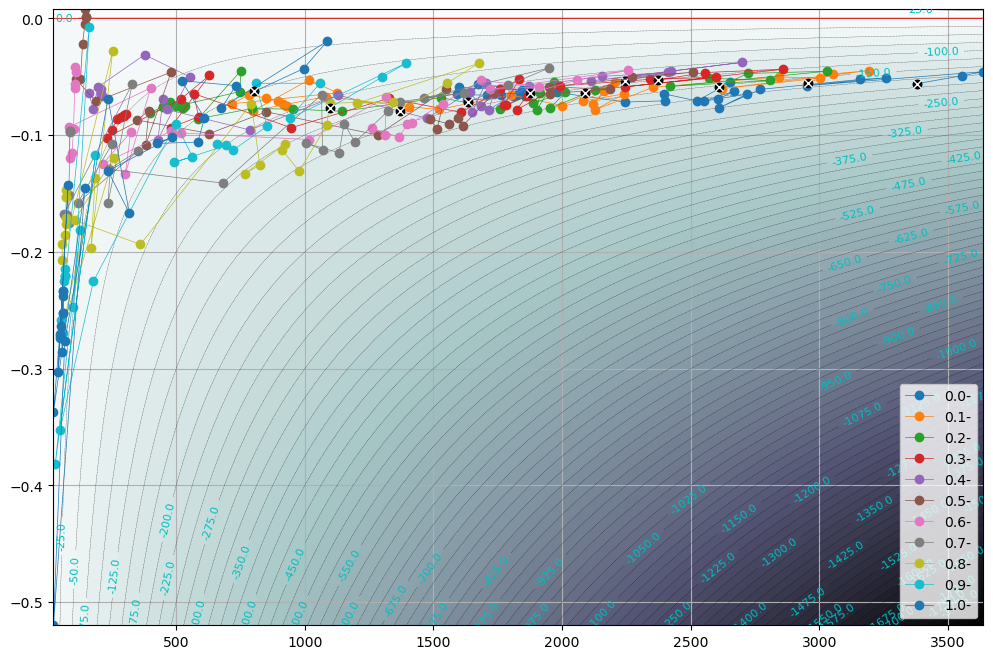

In [39]:
backtest.show_profit_groups(minProduct=0.0)

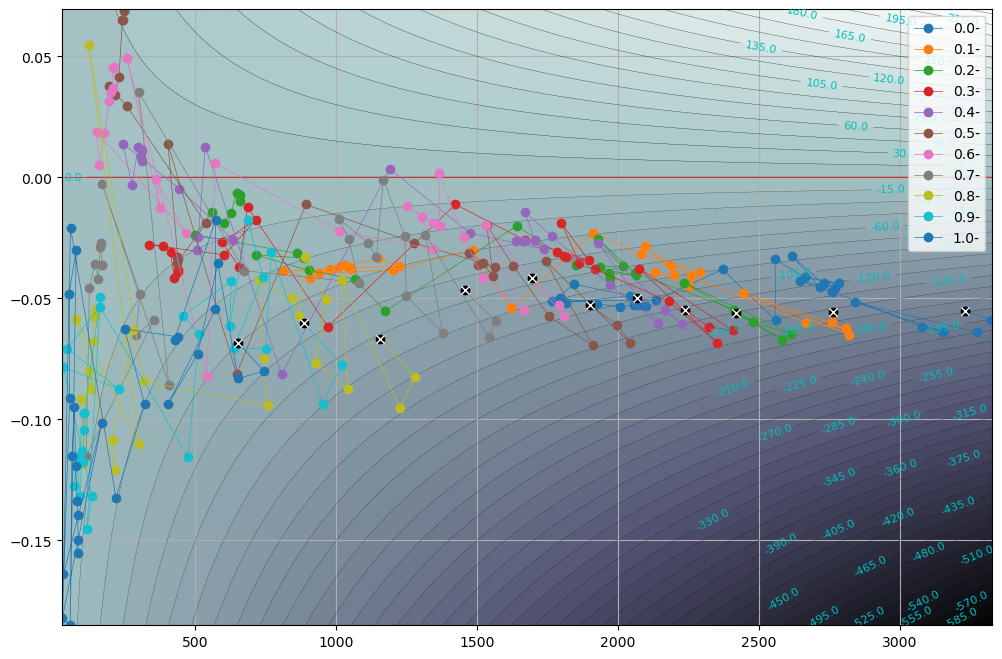

In [40]:
validtest.show_profit_groups(minProduct=0.0)

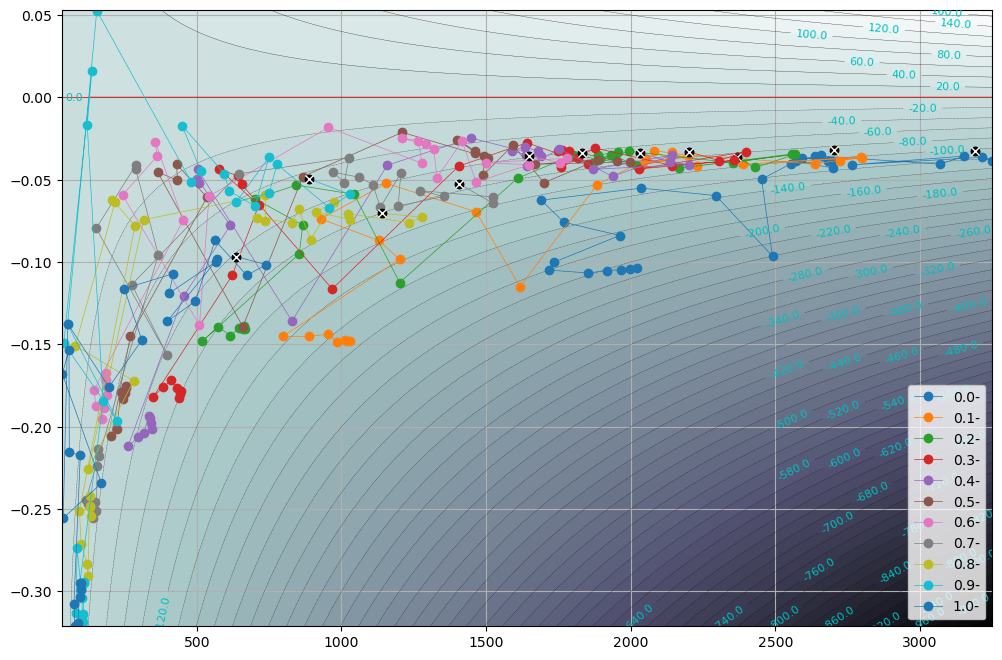

In [41]:
testtest.show_profit_groups(minProduct=0.0)

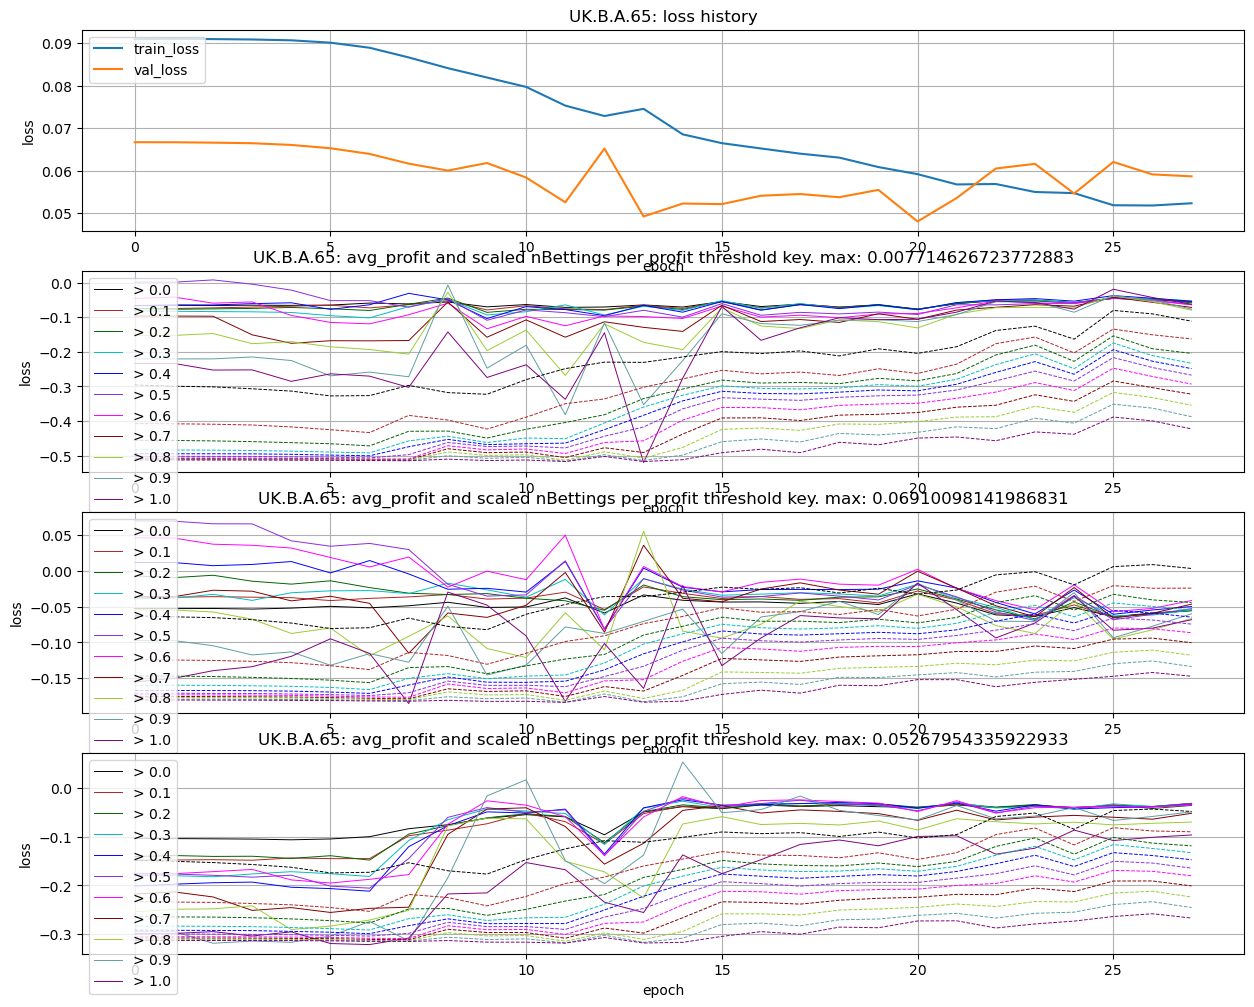

In [42]:
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15,12))
history.show(axes[0]); backtest.show(axes[1]); validtest.show(axes[2]); testtest.show(axes[3]); plt.show()

In [43]:
#-------------------------------------------------------------------------------------------------

profit_series_back, cast_series_back = backtest.find_profit_cast_series()
profit_series_valid, cast_series_valid = validtest.find_profit_cast_series()
profit_series_test, cast_series_test = testtest.find_profit_cast_series()

epoch = 0
for train_loss, val_loss, profits_back, casts_back, profits_valid, casts_valid, profits_test, casts_test \
    in zip(history.history['loss'], history.history['val_loss'], profit_series_back, cast_series_back, profit_series_valid, cast_series_valid, profit_series_test, cast_series_test):
    print_test(epoch, train_loss, val_loss, profits_back, casts_back, profits_valid, casts_valid, profits_test, casts_test)
    epoch += 1

epoch: 0, loss: 0.09090399742126465, val_loss: 0.06668159365653992, profit: [-0.053062755957234385, -0.037961331786939854, -0.007250191140987047, -0.039307049422573674, 0.011376360288033124, 0.06910098141986831, 0.04564488325880167, -0.03612964886885422, -0.05456312837666028, -0.09733024633155679, -0.155089114168111], casts: [2099, 1053, 659, 439, 312, 247, 213, 169, 146, 106, 85]
[14.99224, 0.1851, 81, 0.5-0.9], [14.46356, 0.1662, 87, 0.5-1.0], [11.35881, 0.1515, 75, 0.5-0.8], [9.76326, 0.2325, 42, 0.6-0.9], [9.23458, 0.1924, 48, 0.6-1.0], [8.60993, 0.1411, 61, 0.5-0.7], [6.38231, 0.3191, 20, 0.7-0.9], [6.12983, 0.1703, 36, 0.6-0.8], [5.85363, 0.2251, 26, 0.7-1.0], [5.22898, 0.1341, 39, 0.5-0.6], 
[30.25052, 0.1867, 162, 0.5-1.0], [27.38495, 0.1942, 141, 0.5-0.9], [25.03416, 0.2479, 101, 0.5-0.8], [23.17385, 0.2971, 78, 0.5-0.7], [22.90493, 0.1789, 128, 0.6-1.0], [20.03937, 0.1873, 107, 0.6-0.9], [17.68858, 0.2640, 67, 0.6-0.8], [17.06794, 0.0691, 247, 0.5-], [16.73200, 0.0737, 227, 0

In [44]:
epochs = 500
for epoch in range(history.len(), epochs):
    start_time = time.time()
    history.show(axes[0]); backtest.show(axes[1]); plt.show()
    n = 0; loss = tf.Variable(0.0, dtype=TF_FLOAT); samples_seen = 0
    m = 0; train_loss = 0.0
    
    train_batches = make_train_batches(train_ds)
    for step, ((baseId, sequence, base_bb, mask), (base_label, seq_len_org)) in enumerate(train_batches):
        x = (sequence, base_bb, mask); y = base_label
        batch_loss = train_step(x, y)
        n += 1; loss = loss * (n-1)/n + batch_loss/n
        m += 1; train_loss = train_loss * (m-1)/m + batch_loss/m

        samples_seen += sequence.shape[0]
        if step % 50 == 0:
            show_steps(epoch, step, loss, samples_seen)
            n = 0; loss = 0.0

    show_steps(epoch, step, loss, samples_seen)
    conclude_train_epoch(epoch, train_loss)

    eM365W = EPL.layers[0].layers[0].get_weights()[6]; eM365W = list(tf.reshape(eM365W, (-1,)).numpy())
    print("memory365: {:.4f},  time taken: {:.1f}m                    ".format(eM365W[0] * hyperparams.initial_m365, (time.time()-start_time)/60))
